This example shows demonstration of emulated qubit readout as a function of readout pulse length and qubit T1. It also emulates a qubit T1 curve, and a qubit Rabi oscillation.

Note, this (6/12/23) is the very first, most basic example of the qubit emulator. We are working to improve it to make it more realistic and mathematically accurate so that it is useful to others.

In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('soft/')

from hist_analysis import *
from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from tqdm.notebook import tqdm
from random import *
import seaborn as sns

In [2]:
# Initialize Firmware.
soc = QickTrainingSoc('./qick_training.bit')

# Print information.
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU208

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	6 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, blk 1, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, blk 2, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, blk 3, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=307.200 MHz, f_dds=4915.200 MHz
	5:	axis_sg_mux4_v1 - tProc output 6, envelope memory 0 samples
		DAC tile 0, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz

	8 readout channels:
	0:	axis_pf

In [3]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

In [4]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()

# Enable resonator.
# simu.enable(499.3, t=50, N=1)
#simu.enable(503)
#simu.enable(800)
#simu.enable(1105)

#simu.disable(595)
#simu.disable(600)
#simu.disable(605)

In [5]:
class VnaProgram(NDAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch'],ro_ch=self.cfg['ro_ch'])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],
                             sel     = self.cfg['ro_sel'],
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phrst=0, mode="oneshot")
        
        self.synci(200)  # give processor some time to configure pulses
        
        # Trigger resonator.
        if self.cfg['qubit_jump']:
            self.trigger(pins=[12,13,14,15,16,17,18,19],t=self.us2cycles(0))
    
    def body(self):
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.ro_chs,
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset']),
                     )
        
config={"gen_ch"      : 4,
        "reps"        : 1,
        "pulse_length": 25,
        "pulse_gain"  : 8000, # [DAC units]
        "pulse_freq"  : 600, # [MHz]
        "qubit_jump"  : True
       }

ro_cfg = {
    "ro_ch"     : 4,
    "ro_length" : 0.5,
    "ro_sel"    : 'product',
    "ro_offset" : 10,
    "soft_avgs" : 1
}

config.update(**ro_cfg)

prog = VnaProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment Parameters
* N      = 1000
* fr     = 600 MHz
readout len= 0.5 us
readout len= 10.5 us
readout len= 20.5 us


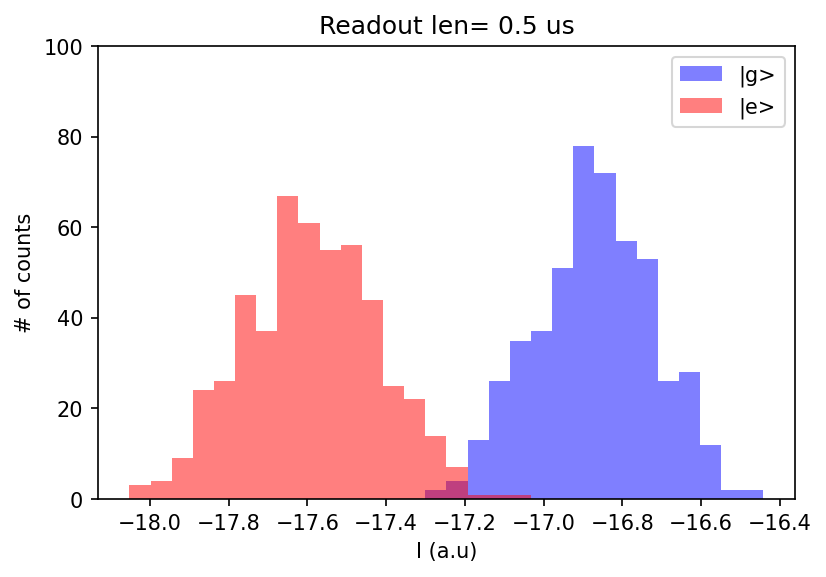

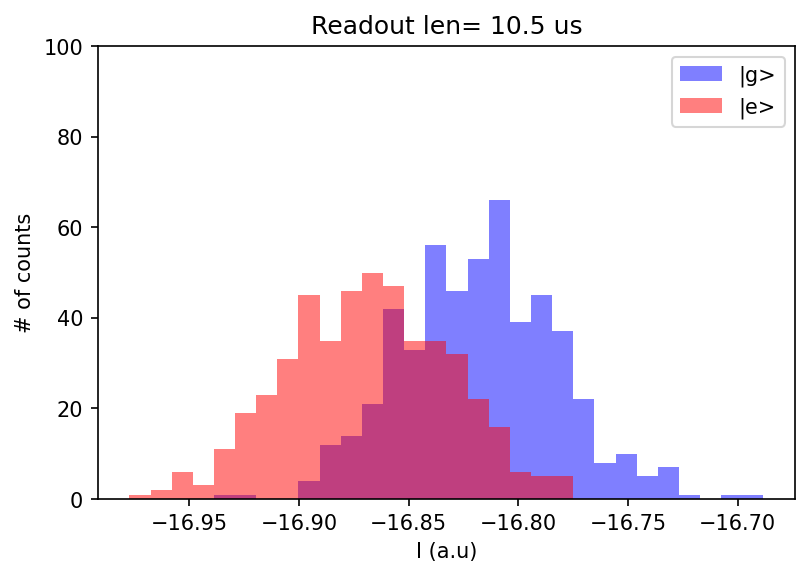

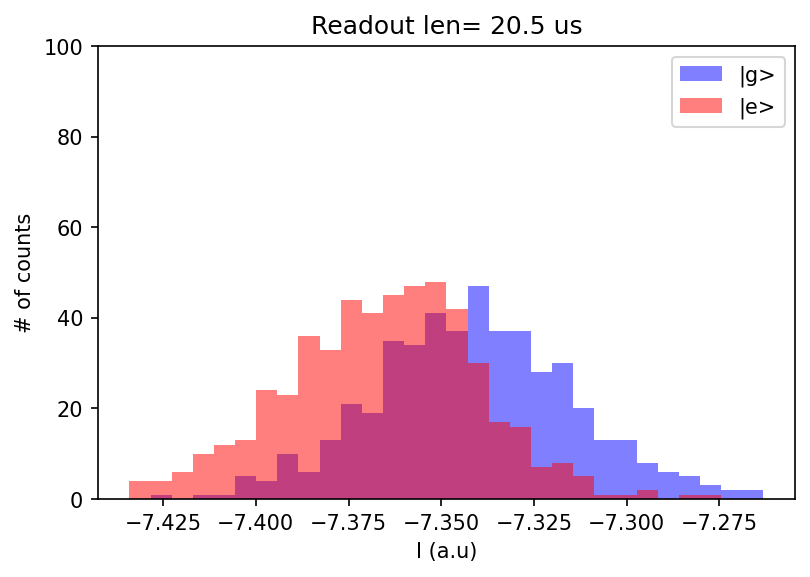

In [6]:
#####################################
### Vary readout time, no T1 decay ###
#####################################
# Resonator frequency.
fr = 600

# Number of points.
N = 1000
print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))

for o in np.arange(0.5,30,10):
    print("readout len= %.1f us" %o)
    i_v = np.zeros(N)
    a_v = np.zeros(N)
    phi_v = np.zeros(N)
    i0 = []
    i1 = []
    a0 = []
    a1 = []
    phi0 = []
    phi1 = []
    for i in range(N):
        # Set resonator decay time.
        tr = 5.5

        # Set resonator.
        simu.enable(fr, t=tr, N=1)
        
        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
        else:
            config['qubit_jump'] = False

        # Set readout length
        ro_cfg['ro_length'] = o
        config.update(**ro_cfg)
        
        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq
        i_v[i] = xi
        a_v[i] = np.abs(xx)
        phi_v[i] = np.angle(xx) + gauss(mu=0,sigma=0.05)

        if config['qubit_jump']:
            i1.append(i_v[i])
            a1.append(a_v[i])
            phi1.append(phi_v[i])
        else:
            i0.append(i_v[i])
            a0.append(a_v[i])
            phi0.append(phi_v[i])


    plt.figure(dpi=150)
    bins=np.histogram(np.hstack((i0,i1)), bins=30)[1] #get the bin edges
    plt.xlabel('I (a.u)')
    plt.ylabel('# of counts')
    plt.ylim(0,100)
    plt.title('Readout len= %.1f us' %o)
    plt.hist(i0, bins,color='b', alpha=0.5,label='|g>')
    plt.hist(i1, bins,color='r', alpha=0.5,label='|e>')
    plt.legend();

Experiment Parameters
* N      = 1000
* fr     = 600 MHz


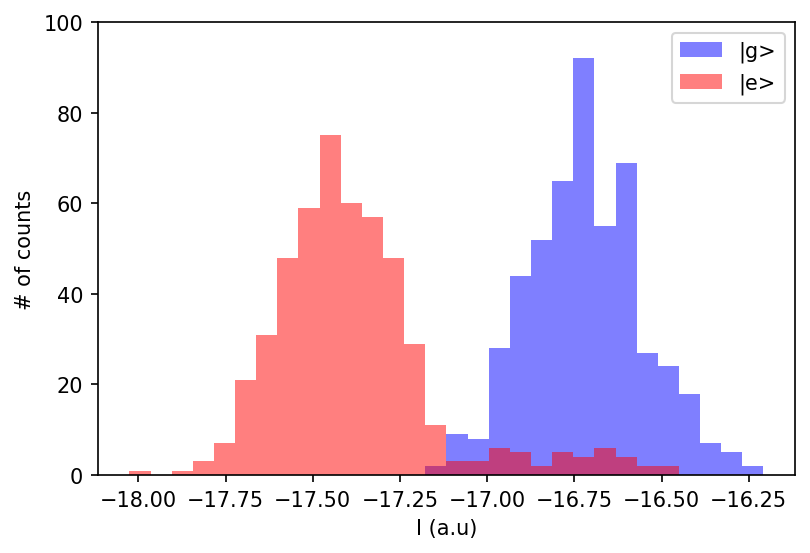

In [7]:
#####################################
### Add a small amount of T1 decay ###
#####################################
# Resonator frequency.
fr = 600

# Number of points.
N = 1000
print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))

i_v = np.zeros(N)
a_v = np.zeros(N)
phi_v = np.zeros(N)
i0 = []
i1 = []
a0 = []
a1 = []
phi0 = []
phi1 = []
for i in range(N):
    # Set resonator decay time.
    tr = 5.5

    # Decide if resonator will jump.
    if random()<0.5:
        config['qubit_jump'] = True
        # Set T1 decay to happen
        if random()>0.95:
            tr = 1
    else:
        config['qubit_jump'] = False

    # Set resonator.
    simu.enable(fr, t=tr, N=1)

    # Set readout length
    ro_cfg['ro_length'] = 0.5
    config.update(**ro_cfg)
        
    # Execute program.
    prog = VnaProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    xi,xq = res[1].item(),res[2].item()

    xx = xi + 1j*xq
    i_v[i] = xi
    a_v[i] = np.abs(xx)
    phi_v[i] = np.angle(xx) + gauss(mu=0,sigma=0.05)

    if config['qubit_jump']:
        i1.append(i_v[i])
        a1.append(a_v[i])
        phi1.append(phi_v[i])
    else:
        i0.append(i_v[i])
        a0.append(a_v[i])
        phi0.append(phi_v[i])


plt.figure(dpi=150)
bins=np.histogram(np.hstack((i0,i1)), bins=30)[1] #get the bin edges
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.ylim(0,100)
plt.hist(i0, bins,color='b', alpha=0.5,label='|g>')
plt.hist(i1, bins,color='r', alpha=0.5,label='|e>')
plt.legend();

In [22]:
#####################################
### Compute readout fidelity with a small amount of T1 decay ###
#####################################
# Resonator frequency.
fr = 600

# Number of points.
N = 1000
print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))

i_v = np.zeros(N)
q_v = np.zeros(N)
a_v = np.zeros(N)
i0 = []
i1 = []
q0 = []
q1 = []
a0 = []
a1 = []
for i in range(N):
    # Set resonator decay time.
    tr = 5.5

    # Decide if resonator will jump.
    if random()<0.5:
        config['qubit_jump'] = True
        # Set T1 decay to happen
        if random()>0.95:
            tr = 1
    else:
        config['qubit_jump'] = False

    # Set resonator.
    simu.enable(fr, t=tr, N=1)

    # Set readout length
    ro_cfg['ro_length'] = 0.5
    config.update(**ro_cfg)
    
    # Execute program.
    prog = VnaProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    xi,xq = res[1].item(),res[2].item()

    xx = xi + 1j*xq
    i_v[i] = xi
    q_v[i] = xq
    a_v[i] = np.abs(xx)

    if config['qubit_jump']:
        i1.append(i_v[i])
        q1.append(q_v[i])
        a1.append(a_v[i])
    else:
        i0.append(i_v[i])
        q0.append(q_v[i])
        a0.append(a_v[i])

#Convert lists to arrays
i0 = np.array(i0)
q0 = np.array(q0)
i1 = np.array(i1)
q1 = np.array(q1)

Experiment Parameters
* N      = 1000
* fr     = 600 MHz


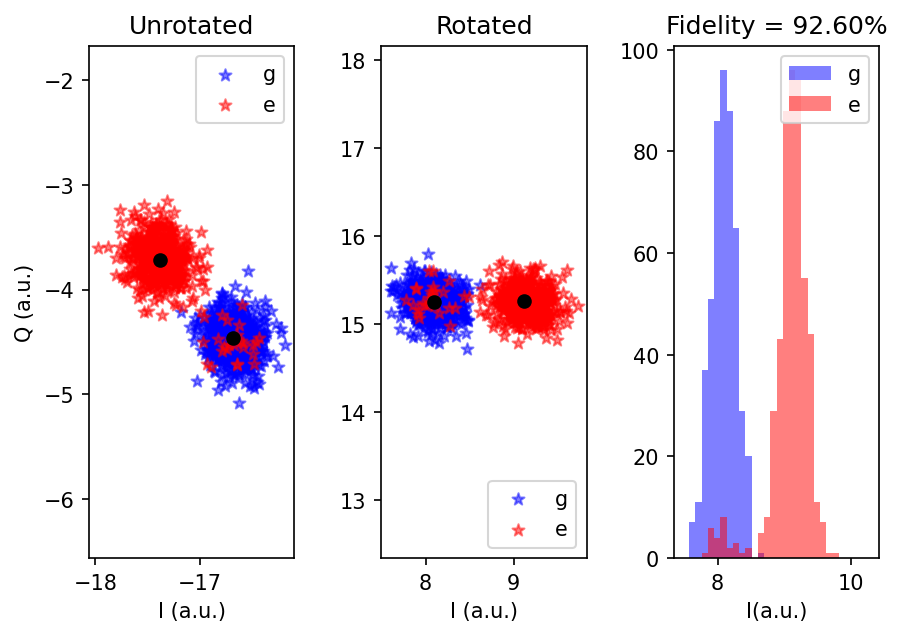

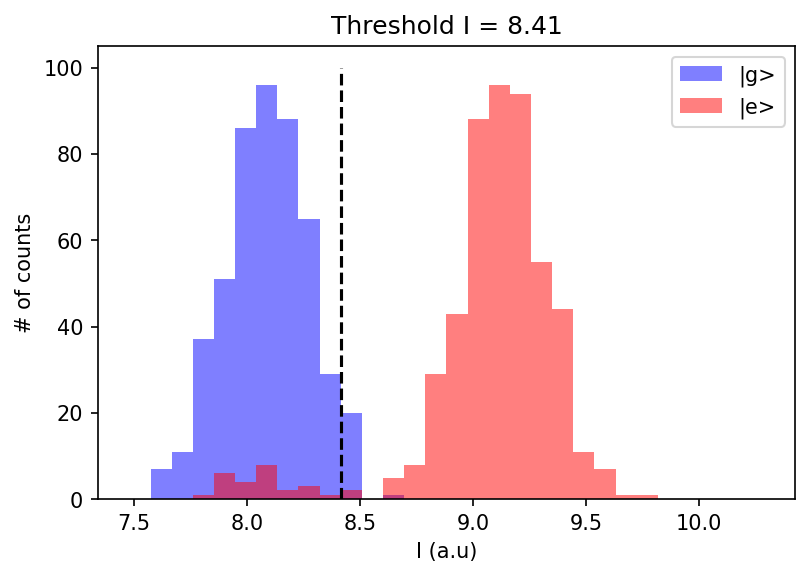

In [9]:
plt.figure(dpi=150)
fid, thresh, theta, xlims = hist_process(data=[i0,q0,i1,q1],numbins=30);

plt.figure(dpi=150)
i0_rot = i0 * np.cos(theta) - q0 * np.sin(theta)
i1_rot = i1 * np.cos(theta) - q1 * np.sin(theta)
bins=np.histogram(np.hstack((i0_rot,i1_rot)), bins=30)[1] #get the bin edges
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.vlines(thresh,ymin=0,ymax=100,color='black',linestyle='--')
plt.hist(i0_rot, bins=30, range=xlims, color='b', alpha=0.5,label='|g>')
plt.hist(i1_rot, bins=30, range=xlims, color='r', alpha=0.5,label='|e>')
plt.title("Threshold I = %.2f"%thresh)
plt.legend();

In [10]:
### This threshold value is good until you re-set the resonators or re-set the firmware.
### Re-running the above two cells will result in distributions with similar thresholds.

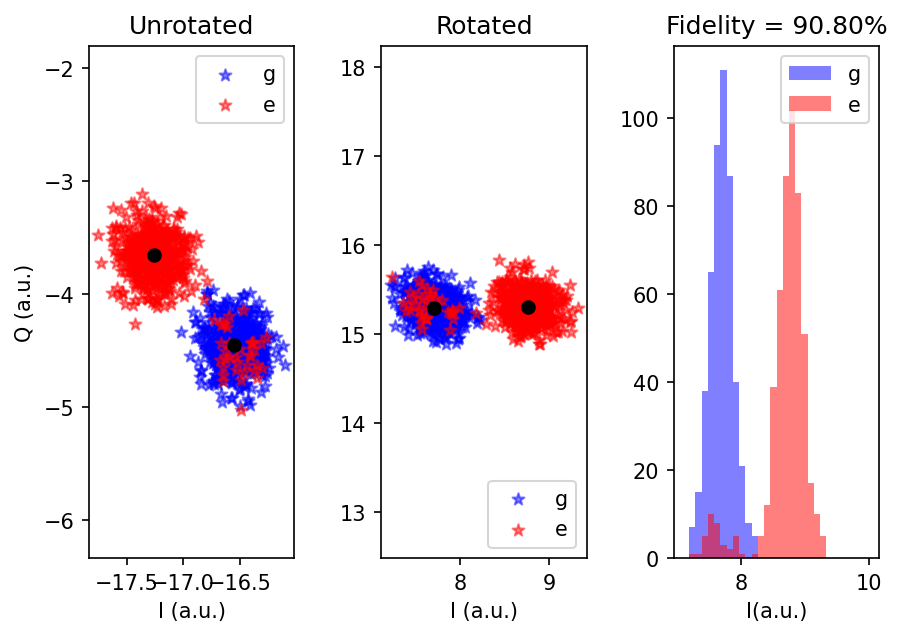

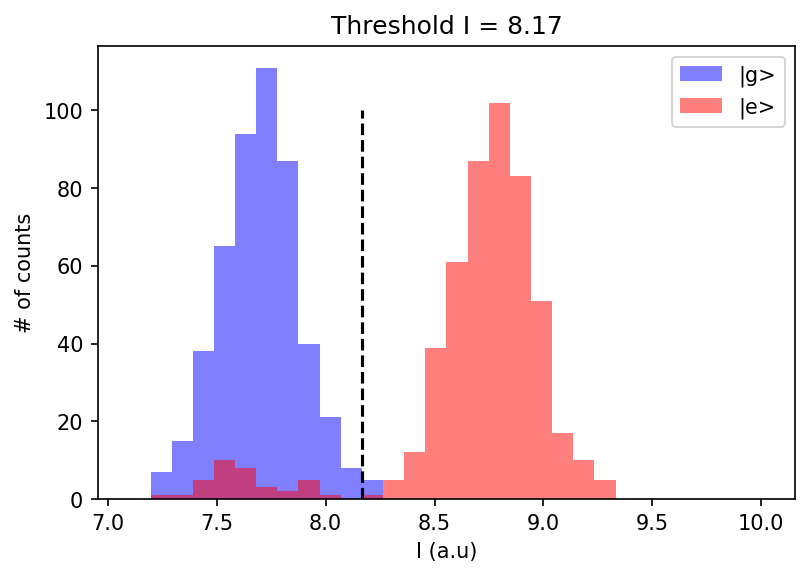

In [23]:
## Re-run `Compute readout fidelity with a small amount of T1 decay' cell, first, then this one.
plt.figure(dpi=150)
fid, thresh, theta, xlims = hist_process(data=[i0,q0,i1,q1],numbins=30);

plt.figure(dpi=150)
i0_rot = i0 * np.cos(theta) - q0 * np.sin(theta)
i1_rot = i1 * np.cos(theta) - q1 * np.sin(theta)
bins=np.histogram(np.hstack((i0_rot,i1_rot)), bins=30)[1] #get the bin edges
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.vlines(thresh,ymin=0,ymax=100,color='black',linestyle='--')
plt.hist(i0_rot, bins=30, range=xlims, color='b', alpha=0.5,label='|g>')
plt.hist(i1_rot, bins=30, range=xlims, color='r', alpha=0.5,label='|e>')
plt.title("Threshold I = %.2f"%thresh)
plt.legend();

In [12]:
def prob_T1(t,T1):
    p = np.exp(-t/T1)
    return p

Experiment Parameters
* N      = 1000
* fr     = 600 MHz
* T1     = 2 (a.u.)
wait time (a.u.) =  0
e, g counts =  456 28
P_e =  0.9421487603305785


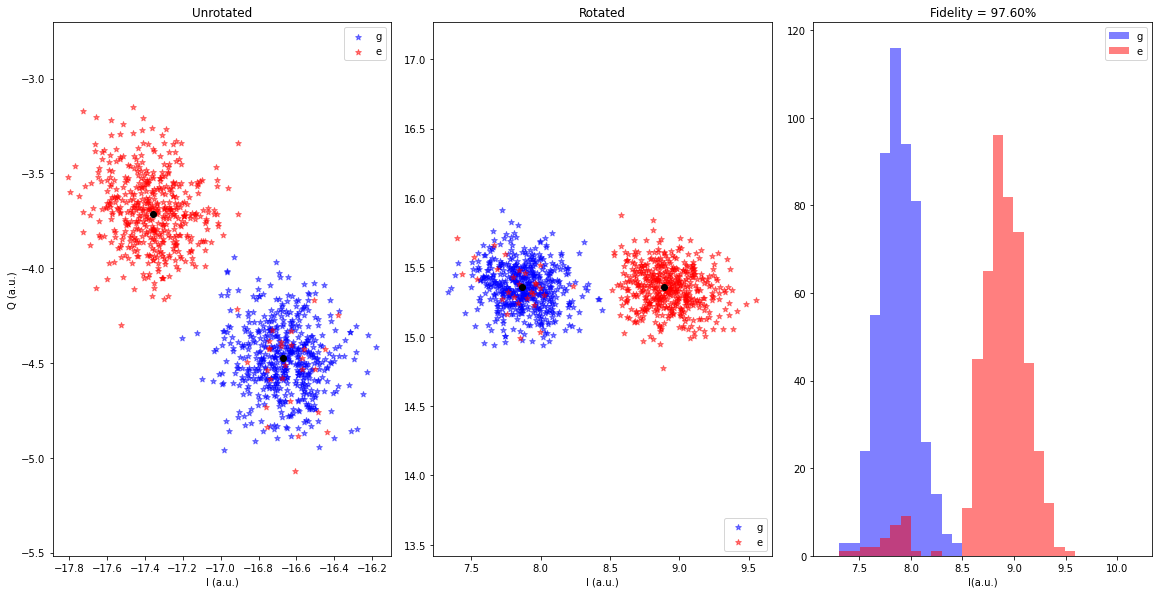

In [13]:
#####################################
### Simulate T1 decay curve ###
#####################################

#####################################
### First, compute readout fidelity with a small amount of T1 decay to obtain threshold, theta values###
#####################################

# Resonator frequency.
fr = 600 # MHz
T1 = 2 # a.u.
# Number of points.
N = 1000

print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))
print('* T1     = {} (a.u.)'.format(T1))


P_es= []
ts = range(0,1)
# Loop over number of T1 experiments
for t in ts:
    print("wait time (a.u.) = ", t)
    i0 = []
    i1 = []
    q0 = []
    q1 = []
    for i in range(N):
        # Set resonator decay time.
        tr = 5.5

        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
            # Set T1 decay to happen
            if random()>0.95:
                tr = 1
        else:
            config['qubit_jump'] = False

        # Set resonator.
        simu.enable(fr, t=tr, N=1)

        # Set readout length
        ro_cfg['ro_length'] = 0.5
        config.update(**ro_cfg)

        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq

        if config['qubit_jump']:
            i1.append(xi)
            q1.append(xq)
        else:
            i0.append(xi)
            q0.append(xq)

    #Convert lists to arrays
    i0 = np.array(i0)
    q0 = np.array(q0)
    i1 = np.array(i1)
    q1 = np.array(q1)
    fid, thresh, theta, xlims = hist_process(data=[i0,q0,i1,q1],numbins=30);
    i0_rot = i0 * np.cos(theta) - q0 * np.sin(theta)
    i1_rot = i1 * np.cos(theta) - q1 * np.sin(theta)
    e_counts = 0
    g_counts = 0
    for x in i1_rot:
        if x < thresh:
            g_counts +=1
        else:
            e_counts +=1
    print("e, g counts = ", e_counts, g_counts)
    P_e = 1-g_counts/(g_counts+e_counts)
    print("P_e = ", P_e)
    P_es.append(P_e)

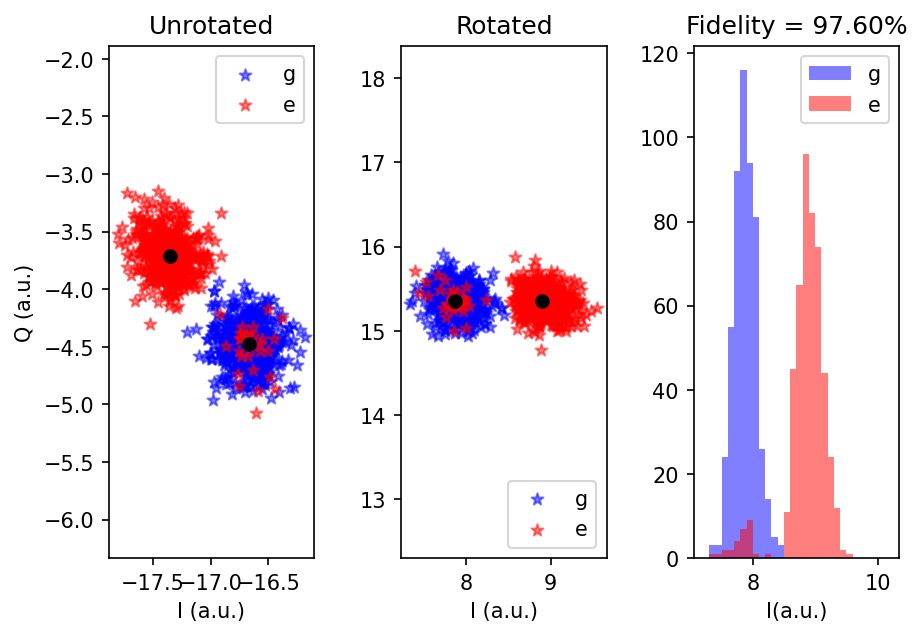

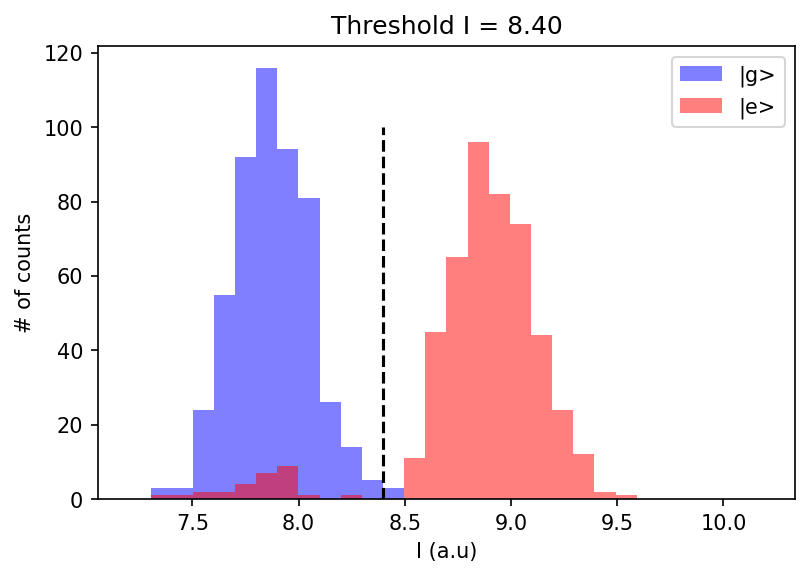

In [14]:
## Re-run `Compute readout fidelity with a small amount of T1 decay' cell, first, then this one.
plt.figure(dpi=150)
fid, thresh, theta, xlims = hist_process(data=[i0,q0,i1,q1],numbins=30);

plt.figure(dpi=150)
i0_rot = i0 * np.cos(theta) - q0 * np.sin(theta)
i1_rot = i1 * np.cos(theta) - q1 * np.sin(theta)
bins=np.histogram(np.hstack((i0_rot,i1_rot)), bins=30)[1] #get the bin edges
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.vlines(thresh,ymin=0,ymax=100,color='black',linestyle='--')
plt.hist(i0_rot, bins=30, range=xlims, color='b', alpha=0.5,label='|g>')
plt.hist(i1_rot, bins=30, range=xlims, color='r', alpha=0.5,label='|e>')
plt.title("Threshold I = %.2f"%thresh)
plt.legend();

In [15]:
thresh_calib = thresh
theta_calib = theta
print(thresh_calib, theta_calib)

8.397504854748812 -2.3069070851994953


In [16]:
#####################################
### Simulate T1 decay curve ###
#####################################

#####################################
### Now, simulate T1 decay curve using those calibrated values ###
#####################################

thresh_calib = thresh
theta_calib = theta

print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))
print('* T1     = {} (a.u.)'.format(T1))


P_es= []
ts = range(0,10)
# Loop over number of T1 experiments
for t in ts:
    print("wait time (a.u.) = ", t)
    i0 = []
    i1 = []
    q0 = []
    q1 = []
    for i in range(N):
        # Set resonator decay time.
        tr = 5.5

        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
            # Set T1 decay to happen
            if random()>prob_T1(t,T1):
                tr = 1
        else:
            config['qubit_jump'] = False

        # Set resonator.
        simu.enable(fr, t=tr, N=1)

        # Set readout length
        ro_cfg['ro_length'] = 0.5
        config.update(**ro_cfg)
    
        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq

        if config['qubit_jump']:
            i1.append(xi)
            q1.append(xq)
        else:
            i0.append(xi)
            q0.append(xq)

    #Convert lists to arrays
    i0 = np.array(i0)
    q0 = np.array(q0)
    i1 = np.array(i1)
    q1 = np.array(q1)
    i0_rot = i0 * np.cos(theta_calib) - q0 * np.sin(theta_calib)
    i1_rot = i1 * np.cos(theta_calib) - q1 * np.sin(theta_calib)
    e_counts = 0
    g_counts = 0
    for x in i1_rot:
        if x < thresh_calib:
            g_counts +=1
        else:
            e_counts +=1
#     print("e, g counts = ", e_counts, g_counts)
    P_e = 1-g_counts/(g_counts+e_counts)
#     print("P_e = ", P_e)
    P_es.append(P_e)

Experiment Parameters
* N      = 1000
* fr     = 600 MHz
* T1     = 2 (a.u.)
wait time (a.u.) =  0
wait time (a.u.) =  1
wait time (a.u.) =  2
wait time (a.u.) =  3
wait time (a.u.) =  4
wait time (a.u.) =  5
wait time (a.u.) =  6
wait time (a.u.) =  7
wait time (a.u.) =  8
wait time (a.u.) =  9


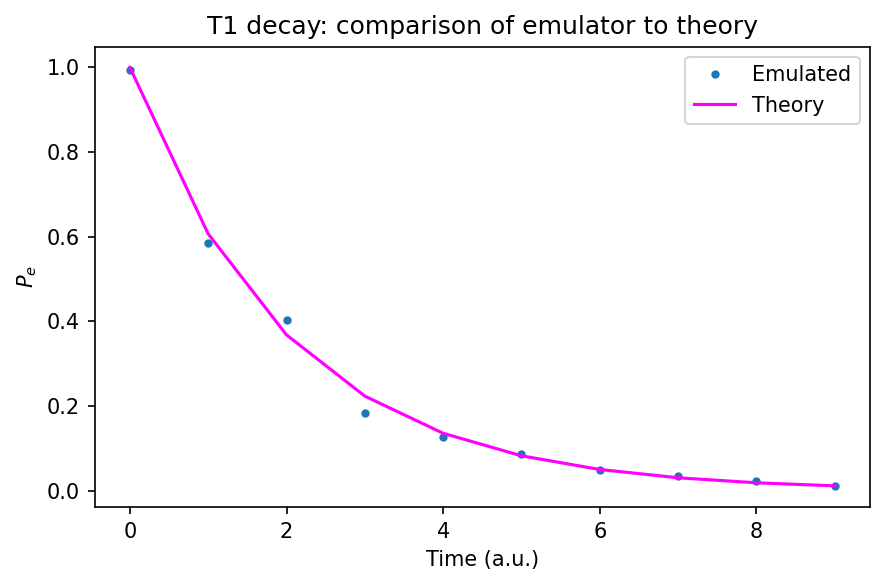

In [17]:
plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.plot(ts,[prob_T1(t,T1) for t in ts],'-',color='magenta',label="Theory")
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("T1 decay: comparison of emulator to theory")
plt.tight_layout();

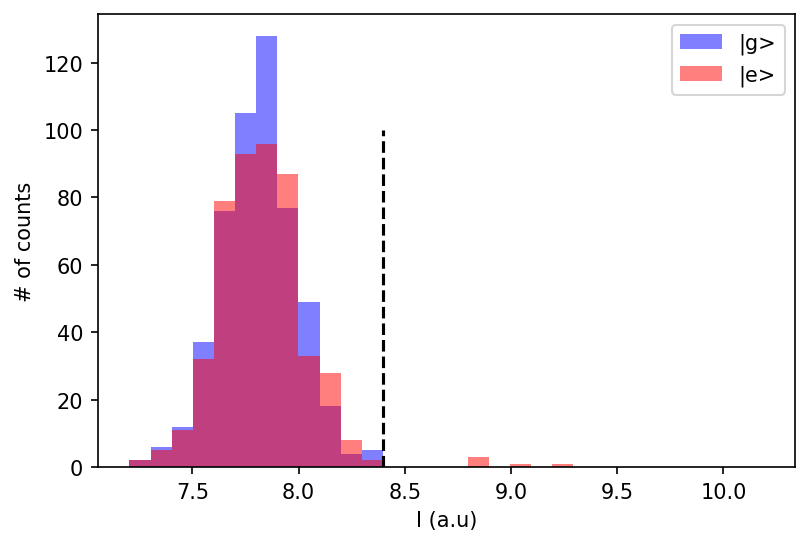

In [18]:
plt.figure(dpi=150)
i0_rot = i0 * np.cos(theta) - q0 * np.sin(theta)
i1_rot = i1 * np.cos(theta) - q1 * np.sin(theta)
bins=np.histogram(np.hstack((i0_rot,i1_rot)), bins=30)[1] #get the bin edges
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.vlines(thresh,ymin=0,ymax=100,color='black',linestyle='--')
plt.hist(i0_rot, bins=30, range=xlims, color='b', alpha=0.5,label='|g>')
plt.hist(i1_rot, bins=30, range=xlims, color='r', alpha=0.5,label='|e>')
# plt.title("Threshold I = %.2f"%thresh)
plt.legend();

In [19]:
def prob_Rabi(t,Omega):
    p = 0.5*np.cos(Omega*t)+0.5
    return p

In [20]:
#####################################
### Simulate Rabi oscillation ###
#####################################

#####################################
### Now, simulate Rabi oscillation using those calibrated values ###
#####################################

thresh_calib = thresh
theta_calib = theta
Omega = 0.5

print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))
print('* Omega     = {} (a.u.)'.format(Omega))


P_es= []
ts = range(0,10)
# Loop over number of Rabi experiments
for t in ts:
    print("wait time (a.u.) = ", t)
    i0 = []
    i1 = []
    q0 = []
    q1 = []
    for i in range(N):
        # Set resonator decay time.
        tr = 5.5

        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
            # Set Rabi oscillation to happen
            if random()>prob_Rabi(t,Omega):
                tr = 1
        else:
            config['qubit_jump'] = False

        # Set resonator.
        simu.enable(fr, t=tr, N=1)

        # Set readout length
        ro_cfg['ro_length'] = 0.5
        config.update(**ro_cfg)
    
        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq

        if config['qubit_jump']:
            i1.append(xi)
            q1.append(xq)
        else:
            i0.append(xi)
            q0.append(xq)

    #Convert lists to arrays
    i0 = np.array(i0)
    q0 = np.array(q0)
    i1 = np.array(i1)
    q1 = np.array(q1)
    i0_rot = i0 * np.cos(theta_calib) - q0 * np.sin(theta_calib)
    i1_rot = i1 * np.cos(theta_calib) - q1 * np.sin(theta_calib)
    e_counts = 0
    g_counts = 0
    for x in i1_rot:
        if x < thresh_calib:
            g_counts +=1
        else:
            e_counts +=1
#     print("e, g counts = ", e_counts, g_counts)
    P_e = 1-g_counts/(g_counts+e_counts)
#     print("P_e = ", P_e)
    P_es.append(P_e)

Experiment Parameters
* N      = 1000
* fr     = 600 MHz
* Omega     = 0.5 (a.u.)
wait time (a.u.) =  0
wait time (a.u.) =  1
wait time (a.u.) =  2
wait time (a.u.) =  3
wait time (a.u.) =  4
wait time (a.u.) =  5
wait time (a.u.) =  6
wait time (a.u.) =  7
wait time (a.u.) =  8
wait time (a.u.) =  9


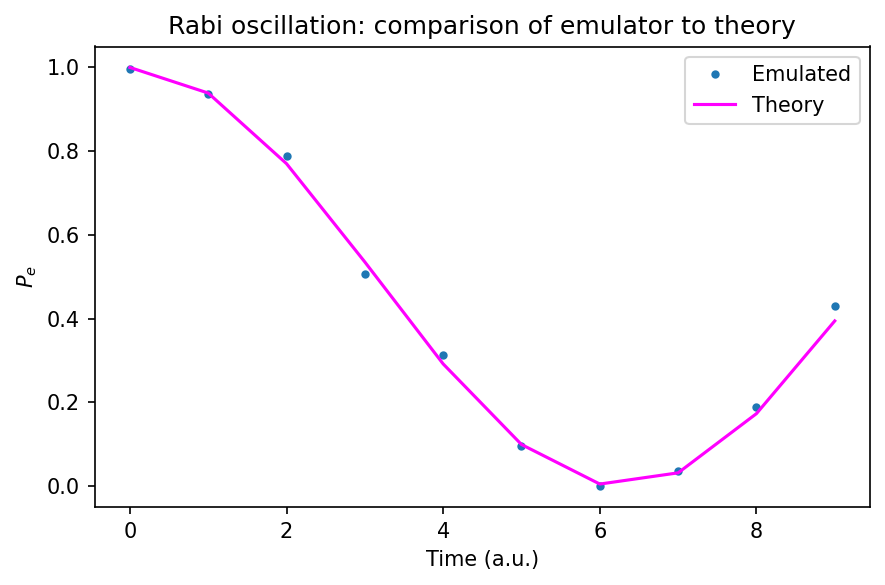

In [21]:
plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.plot(ts,[prob_Rabi(t,Omega) for t in ts],'-',color='magenta',label="Theory")
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("Rabi oscillation: comparison of emulator to theory")
plt.tight_layout();